In [19]:
import numpy as np
import pandas as pd
import gensim.downloader as api
import text_hammer as th
import matplotlib.pyplot as plt

from keras.preprocessing.text import Tokenizer,  text_to_word_sequence
from keras.layers import Embedding, Dense, Bidirectional, Embedding, LSTM, Bidirectional, TimeDistributed, Dense, Input
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.train import latest_checkpoint
from keras import initializers
from keras.layers import Layer
import keras.backend as K

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
nltk.download('stopwords')

from data_preprocessing import load_sst
import utils

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kiann\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Dataset loading

In [20]:
# Load SST dataset
train_data, train_labels, test_data, test_labels, dev_data, dev_labels = load_sst()


INFO: SST-2 loaded


In [21]:
# Load into dataframes

df_train = pd.DataFrame({'content':train_data, 'sentiment':train_labels})
df_train.reset_index(drop=True, inplace=True)

df_test = pd.DataFrame({'content':dev_data, 'sentiment':dev_labels})
df_test.reset_index(drop=True, inplace=True)

df_imdb = pd.read_csv("data/IMDB Dataset.csv")
df_imdb = df_imdb.rename(columns={"review": "content"})
df_imdb['sentiment'] = df_imdb['sentiment'].map({"positive":1, "negative":0})
# df_imdb = df_imdb.sample(n=1000)
df_imdb.head(5)

,content,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [22]:
print(df_train.shape)
print(df_test.shape)
print(df_imdb.shape)

(67349, 2)
(872, 2)
(50000, 2)


# Configs

In [6]:
# Configs
max_sent_length = 50
max_number_of_sent = 50
max_number_of_words = 50000
np.random.seed(123)

In [7]:
def Tokenize(texts, max_sent_length, max_number_of_sent, max_number_of_words, tokenizer, word_index):
    articles = texts.map(lambda x: sent_tokenize(x))

    data = np.zeros((len(texts), max_number_of_sent, max_sent_length), dtype='int32')
    failCount = 0
    for i, sentences in enumerate(articles):
        for j, sent in enumerate(sentences):
            if j< max_number_of_sent:
                wordTokens = text_to_word_sequence(sent)
                k=0
                for _, word in enumerate(wordTokens):
                    try:
                      if k<max_sent_length and tokenizer.word_index[word]<max_number_of_words:
                            data[i,j,k] = tokenizer.word_index[word]
                            k=k+1
                    except:
                      data[i,j,k] = 0
                      k=k+1
                      failCount+=1
    print('No. of %s unique tokens.' % len(word_index))
    print(f'Failed to tokenize {failCount} words')
    return data

In [8]:
def Train_Val_Split(data, ori_df, val_size = 0.2):
    # Encode labels
    labels = to_categorical(np.asarray(ori_df['sentiment']))
    print('Shape of data tensor:', data.shape)
    print('Shape of label tensor:', labels.shape)

    # Shuffle data
    indices = np.arange(data.shape[0])
    np.random.shuffle(indices)
    data = data[indices]
    labels = labels[indices]
    
    # Split dataset
    if(val_size == 0):
        return data, labels, None, None
    
    nb_validation_samples = int(val_size * data.shape[0])

    xtrain = data[:-nb_validation_samples]
    ytrain = labels[:-nb_validation_samples]
    xval = data[-nb_validation_samples:]
    yval = labels[-nb_validation_samples:]
    return xtrain, ytrain, xval, yval

In [9]:
## Create an embedding weight matrix based on word2vec that used in a Keras Embedding layer. 

def embed(model, tokenizer, GLOVE_DIM):
    embed_size = GLOVE_DIM
    embedding_matrix = np.zeros((len(tokenizer.word_index)+1, embed_size))

    hits = 0
    misses = 0

    # embedding matrix
    for word, i in tokenizer.word_index.items():
        try:
            embedding_vector = model.get_vector(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
                hits += 1
            else:
                misses += 1
        except:
            misses += 1
        
            
    print("Converted %d words (%d misses)" % (hits, misses))
    return embedding_matrix

In [10]:
class AttentionLayer(Layer):
    """
    Hierarchial Attention Layer as described by Hierarchical Attention Networks for Document Classification(2016)
    - Yang et. al.
    Source: https://www.cs.cmu.edu/~hovy/papers/16HLT-hierarchical-attention-networks.pdf
    Theano backend
    """
    def __init__(self,attention_dim=100,return_coefficients=False,**kwargs):
        # Initializer 
        self.supports_masking = True
        self.return_coefficients = return_coefficients
        self.init = initializers.get('glorot_uniform') # initializes values with uniform distribution
        self.attention_dim = attention_dim
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Builds all weights
        # W = Weight matrix, b = bias vector, u = context vector
        assert len(input_shape) == 3
        self.W = K.variable(self.init((input_shape[-1], self.attention_dim)),name='W')
        self.b = K.variable(self.init((self.attention_dim, )),name='b')
        self.u = K.variable(self.init((self.attention_dim, 1)),name='u')
        self._trainable_weights = [self.W, self.b, self.u]

        super(AttentionLayer, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, hit, mask=None):
        # Here, the actual calculation is done
        uit = K.bias_add(K.dot(hit, self.W),self.b)
        uit = K.tanh(uit)
        
        ait = K.dot(uit, self.u)
        ait = K.squeeze(ait, -1)
        ait = K.exp(ait)
        
        if mask is not None:
            ait *= K.cast(mask, K.floatx())

        ait /= K.cast(K.sum(ait, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        ait = K.expand_dims(ait)
        weighted_input = hit * ait
        
        if self.return_coefficients:
            return [K.sum(weighted_input, axis=1), ait]
        else:
            return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        if self.return_coefficients:
            return [(input_shape[0], input_shape[-1]), (input_shape[0], input_shape[-1], 1)]
        else:
            return input_shape[0], input_shape[-1]

In [11]:

def evaluate_model(x_train, y_train, x_val, y_val, wordLen, GLOVE_DIM, embedding_matrix):
    # Loads the weights
    embedding_layer = Embedding(wordLen, output_dim=GLOVE_DIM, input_length=max_sent_length, weights=[embedding_matrix],trainable=False)

    # Hierarchal Attention Network word-sentence layers
    # Word
    sentence_input = Input(shape=(max_sent_length,), dtype='int32')
    embedded_sequences = embedding_layer(sentence_input)
    lstm_layer = Bidirectional(layer=LSTM(100, dropout=0.2, return_sequences=True))(embedded_sequences)
    word_att,word_coeffs = AttentionLayer(GLOVE_DIM,return_coefficients=True,name='word_attention')(lstm_layer)
    sentEncoder = Model(sentence_input, word_att)
    print(sentEncoder.summary())

    # Sentence
    article_input = Input(shape=(max_number_of_sent,max_sent_length), dtype='int32')
    article_encoder = TimeDistributed(sentEncoder)(article_input)
    lstm_layer_sent = Bidirectional(LSTM(100, dropout=0.2, return_sequences=True))(article_encoder)
    sent_att,sent_coeffs = AttentionLayer(GLOVE_DIM,return_coefficients=True,name='sent_attention')(lstm_layer_sent)
    preds = Dense(len(df_train['sentiment'].unique()), activation='softmax')(sent_att)
    han_model = Model(article_input, preds)


    han_model.compile(loss='categorical_crossentropy',
                optimizer='rmsprop',
                metrics=['acc'])
    print(han_model.summary())

    # Create early stopping callback
    es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)
    # Create model checkpoint callback 
    checkpoint_path = "training_1/cp.ckpt"
    cp_callback = ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True,verbose=1)


    # Fit training model to SST dataset
    import os
    # if not os.listdir(checkpoint_path.split("/")[0]):
    history = han_model.fit(x_train, y_train, epochs=100, batch_size=64, verbose=1,validation_data=(x_val,y_val),callbacks= [es])#, cp_callback])
    # else:
    #    latest = latest_checkpoint(checkpoint_path.split(" /")[0])
    #    han_model.load_weights(latest)
    #    history = han_model.evaluate(xval, yval, verbose=2)

    return history, han_model

In [12]:
def print_stats(history):
    last_accuracy = "{:.3f}".format(history.history['acc'][-1])
    print("Training Accuracy:", last_accuracy)

    # plt.plot(history.history['acc'])
    # plt.plot(history.history['val_acc'])
    # plt.title('Training Accuracy vs Validation Accuracy')
    # plt.ylabel('Accuracy')
    # plt.xlabel('Epoch')
    # plt.legend(['Train', 'Validation'], loc='upper left')
    # plt.show()

    
    epochs = [i*3 for i in range(0, len(history.history['acc'])//3 + 1)]
    plt.figure(figsize=(4, 3))
    plt.plot(history.history['acc'], marker='o', linestyle='-', color='blue', label='Train', linewidth=2, markersize=5)
    plt.plot(history.history['val_acc'], marker='o', linestyle='-', color='orange', label='Test', linewidth=2, markersize=5)

    plt.xticks(epochs)
    plt.xlim(-1, len(history.history['acc'])) 
    plt.tight_layout()
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Training Loss vs Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    

# Experiment Part 1 - 4 Word2Vec models with no text-preprocessing and removal of stopwords

In [13]:
df_train_ori = df_train.copy()
df_test_ori = df_test.copy()
df_imdb_ori = df_imdb.copy()

INFO: loading projection weights from C:\Users\Kiann/gensim-data\word2vec-google-news-300\word2vec-google-news-300.gz
INFO: KeyedVectors lifecycle event {'msg': 'loaded (3000000, 300) matrix of type float32 from C:\\Users\\Kiann/gensim-data\\word2vec-google-news-300\\word2vec-google-news-300.gz', 'binary': True, 'encoding': 'utf8', 'datetime': '2024-04-14T03:29:14.305226', 'gensim': '4.3.2', 'python': '3.9.19 (main, Mar 21 2024, 17:21:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19045-SP0', 'event': 'load_word2vec_format'}


No. of 773164 unique tokens.
Failed to tokenize 3066 words
No. of 773164 unique tokens.
Failed to tokenize 77 words
No. of 124252 unique tokens.
Failed to tokenize 143425 words
Shape of data tensor: (67349, 50, 50)
Shape of label tensor: (67349, 2)
Shape of data tensor: (872, 50, 50)
Shape of label tensor: (872, 2)
Shape of data tensor: (50000, 50, 50)
Shape of label tensor: (50000, 2)
Converted 159622 words (613542 misses)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding (Embedding)       (None, 50, 300)           231949500 
                                                                 
 bidirectional (Bidirectiona  (None, 50, 200)          320800    
 l)                                                              
                             

c:\Users\Kiann\miniconda3\envs\tf\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


None
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 50, 50)]          0         
                                                                 
 time_distributed (TimeDistr  (None, 50, 200)          232330900 
 ibuted)                                                         
                                                                 
 bidirectional_1 (Bidirectio  (None, 50, 200)          240800    
 nal)                                                            
                                                                 
 sent_attention (AttentionLa  [(None, 200),            60600     
 yer)                         (None, 50, 1)]                     
                                                                 
 dense (Dense)               (None, 2)                 402       
                                                      

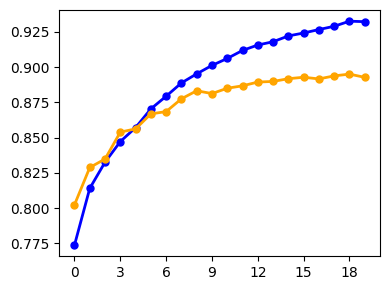

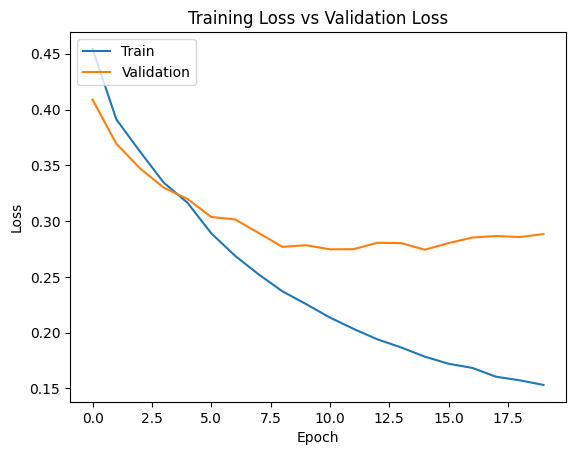

Test set evaluation
28/28 - 1s - loss: 0.6315 - acc: 0.8200 - 719ms/epoch - 26ms/step
(50000, 50, 50)
(50000, 2)
imdb set evaluation
1563/1563 - 40s - loss: 1.1650 - acc: 0.6918 - 40s/epoch - 26ms/step


INFO: loading projection weights from C:\Users\Kiann/gensim-data\glove-wiki-gigaword-300\glove-wiki-gigaword-300.gz
INFO: KeyedVectors lifecycle event {'msg': 'loaded (400000, 300) matrix of type float32 from C:\\Users\\Kiann/gensim-data\\glove-wiki-gigaword-300\\glove-wiki-gigaword-300.gz', 'binary': False, 'encoding': 'utf8', 'datetime': '2024-04-14T04:01:53.893321', 'gensim': '4.3.2', 'python': '3.9.19 (main, Mar 21 2024, 17:21:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19045-SP0', 'event': 'load_word2vec_format'}


No. of 339251 unique tokens.
Failed to tokenize 1553 words
No. of 339251 unique tokens.
Failed to tokenize 42 words
No. of 124252 unique tokens.
Failed to tokenize 280767 words
Shape of data tensor: (67349, 50, 50)
Shape of label tensor: (67349, 2)
Shape of data tensor: (872, 50, 50)
Shape of label tensor: (872, 2)
Shape of data tensor: (50000, 50, 50)
Shape of label tensor: (50000, 2)
Converted 337393 words (1858 misses)
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 50, 300)           101775600 
                                                                 
 bidirectional_2 (Bidirectio  (None, 50, 200)          320800    
 nal)                                                            
                             

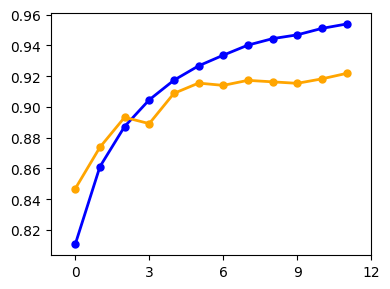

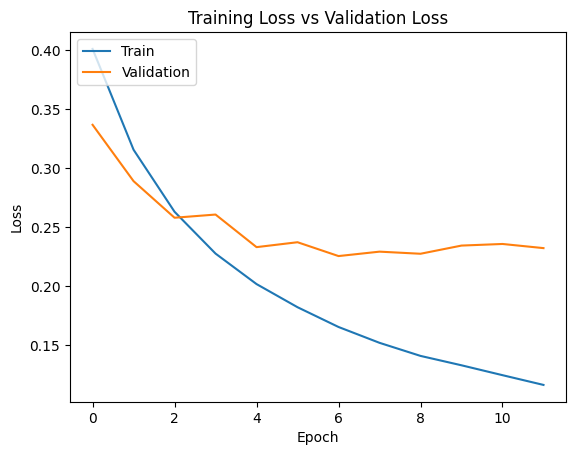

Test set evaluation
28/28 - 1s - loss: 0.5328 - acc: 0.8429 - 731ms/epoch - 26ms/step
(50000, 50, 50)
(50000, 2)
imdb set evaluation
1563/1563 - 40s - loss: 0.8944 - acc: 0.7381 - 40s/epoch - 26ms/step


INFO: loading projection weights from C:\Users\Kiann/gensim-data\glove-wiki-gigaword-100\glove-wiki-gigaword-100.gz
INFO: KeyedVectors lifecycle event {'msg': 'loaded (400000, 100) matrix of type float32 from C:\\Users\\Kiann/gensim-data\\glove-wiki-gigaword-100\\glove-wiki-gigaword-100.gz', 'binary': False, 'encoding': 'utf8', 'datetime': '2024-04-14T04:21:34.382845', 'gensim': '4.3.2', 'python': '3.9.19 (main, Mar 21 2024, 17:21:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19045-SP0', 'event': 'load_word2vec_format'}


No. of 339251 unique tokens.
Failed to tokenize 1553 words
No. of 339251 unique tokens.
Failed to tokenize 42 words
No. of 124252 unique tokens.
Failed to tokenize 280767 words
Shape of data tensor: (67349, 50, 50)
Shape of label tensor: (67349, 2)
Shape of data tensor: (872, 50, 50)
Shape of label tensor: (872, 2)
Shape of data tensor: (50000, 50, 50)
Shape of label tensor: (50000, 2)
Converted 337393 words (1858 misses)
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding_2 (Embedding)     (None, 50, 100)           33925200  
                                                                 
 bidirectional_4 (Bidirectio  (None, 50, 200)          160800    
 nal)                                                            
                             

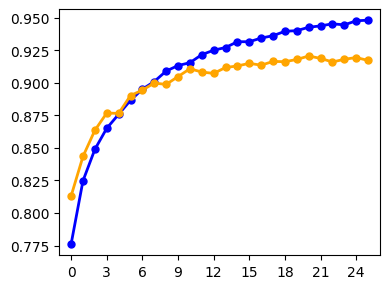

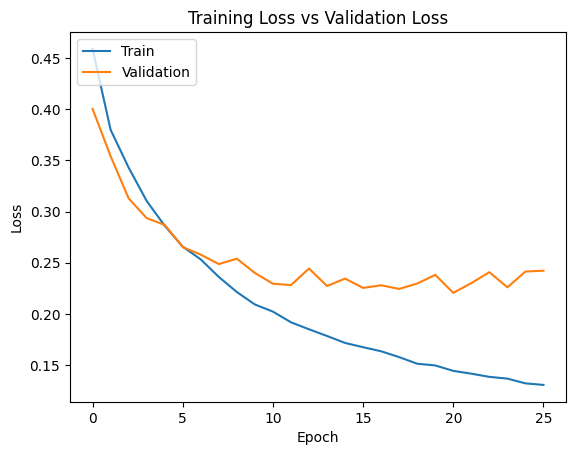

Test set evaluation
28/28 - 1s - loss: 0.5028 - acc: 0.8544 - 571ms/epoch - 20ms/step
(50000, 50, 50)
(50000, 2)
imdb set evaluation
1563/1563 - 32s - loss: 1.3477 - acc: 0.7473 - 32s/epoch - 20ms/step


INFO: loading projection weights from C:\Users\Kiann/gensim-data\glove-wiki-gigaword-200\glove-wiki-gigaword-200.gz
INFO: KeyedVectors lifecycle event {'msg': 'loaded (400000, 200) matrix of type float32 from C:\\Users\\Kiann/gensim-data\\glove-wiki-gigaword-200\\glove-wiki-gigaword-200.gz', 'binary': False, 'encoding': 'utf8', 'datetime': '2024-04-14T04:51:35.708304', 'gensim': '4.3.2', 'python': '3.9.19 (main, Mar 21 2024, 17:21:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19045-SP0', 'event': 'load_word2vec_format'}


No. of 339251 unique tokens.
Failed to tokenize 1553 words
No. of 339251 unique tokens.
Failed to tokenize 42 words
No. of 124252 unique tokens.
Failed to tokenize 280767 words
Shape of data tensor: (67349, 50, 50)
Shape of label tensor: (67349, 2)
Shape of data tensor: (872, 50, 50)
Shape of label tensor: (872, 2)
Shape of data tensor: (50000, 50, 50)
Shape of label tensor: (50000, 2)
Converted 337393 words (1858 misses)
Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding_3 (Embedding)     (None, 50, 200)           67850400  
                                                                 
 bidirectional_6 (Bidirectio  (None, 50, 200)          240800    
 nal)                                                            
                             

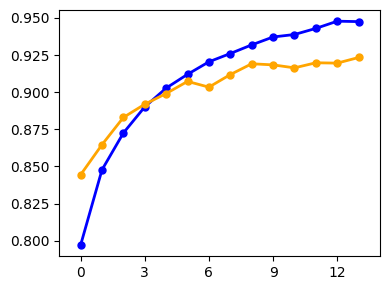

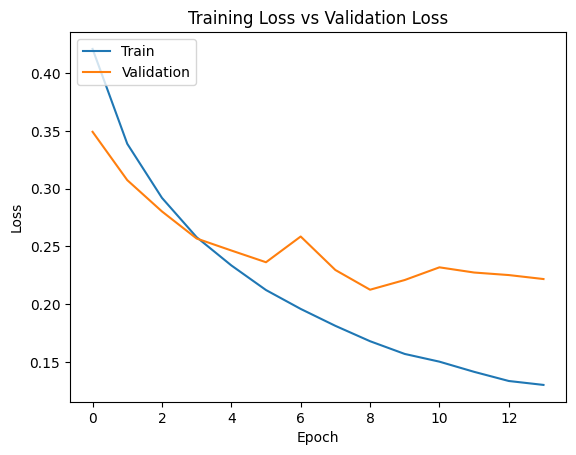

Test set evaluation
28/28 - 1s - loss: 0.4535 - acc: 0.8475 - 659ms/epoch - 24ms/step
(50000, 50, 50)
(50000, 2)
imdb set evaluation
1563/1563 - 36s - loss: 1.1687 - acc: 0.7019 - 36s/epoch - 23ms/step


In [14]:
for model_type in ['word2vec-google-news-300','glove-wiki-gigaword-300','glove-wiki-gigaword-100', 'glove-wiki-gigaword-200']:
        w2vModel = api.load(model_type)
        GLOVE_DIM = int(model_type.split('-')[-1])

        # Reset dataframes
        df_train = df_train_ori.copy()
        df_test = df_test_ori.copy()
        df_imdb = df_imdb_ori.copy()
        
        # Tokenize all data for HAN
        texts = df_train['content']
        test_text = df_test['content']
        imdb_text = df_imdb['content']


        # Get all sentences
        test_articles = test_text.map(lambda x: sent_tokenize(x))

        # Create 3D data with tokenizer word_index. Neglect words which are not in word_index
        tokenizer = Tokenizer(num_words=max_number_of_words)

        # Fit word2vec vocab list onto tokenizer
        words = list(w2vModel.index_to_key)
        tokenizer.fit_on_texts(words)


        # tokenizer.fit_on_texts(texts)
        word_index = tokenizer.word_index

        # # Tokenize train test data
        data = Tokenize(texts, max_sent_length, max_number_of_sent, max_number_of_words, tokenizer, word_index)
        test_data = Tokenize(test_text, max_sent_length, max_number_of_sent, max_number_of_words, tokenizer, word_index)

        # Just to get the unique token count, still use original tokenizer
        imdb_tokenizer = Tokenizer(num_words=max_number_of_words)
        imdb_tokenizer.fit_on_texts(imdb_text)
        imdb_word_index = imdb_tokenizer.word_index

        imdb_data = Tokenize(imdb_text, max_sent_length, max_number_of_sent, max_number_of_words, tokenizer, imdb_word_index)

        # # Split training and validation sets
        xtrain, ytrain, xval, yval = Train_Val_Split(data,df_train, 0.2)
        xtest, ytest, _, _ = Train_Val_Split(test_data,df_test, 0)
        xtrain_imdb, ytrain_imdb, _, _ = Train_Val_Split(imdb_data,df_imdb,0)
        wordLen = len(tokenizer.word_index)+1

        # Make word2vec embedding 3D weight matrix
        embedding_matrix = embed (w2vModel, tokenizer, GLOVE_DIM)
        
        # Evaluate model
        history, han_model = evaluate_model(xtrain, ytrain, xval, yval, wordLen, GLOVE_DIM, embedding_matrix)

        # Final Summary of run
        print(f"Evaluation of {model_type}")
        print_stats(history)
        # Evaluate model on sst test dataset
        print("Test set evaluation")
        result = han_model.evaluate(xtest, ytest, verbose=2)

        # Evaluate model on imdb dataset
        print(xtrain_imdb.shape)
        print(ytrain_imdb.shape)

        print("imdb set evaluation")
        result = han_model.evaluate(xtrain_imdb, ytrain_imdb, verbose=2)

# Experiment Part 2 - 4 Word2Vec models with text-preprocessing and removal of stopwords

In [15]:
df_train = df_train_ori.copy()
df_test = df_test_ori.copy()
df_imdb =df_imdb_ori.copy()

utils.remove_special_content(df_train)
utils.remove_special_content(df_test)
utils.remove_special_content(df_imdb)

df_train_pre = df_train.copy()
df_test_pre = df_test.copy()
df_imdb_pre = df_imdb.copy()

  0%|          | 0/67349 [00:00<?, ?it/s]

  0%|          | 0/67349 [00:00<?, ?it/s]

  0%|          | 0/67349 [00:00<?, ?it/s]

c:\Users\Kiann\miniconda3\envs\tf\lib\site-packages\bs4\__init__.py:329: MarkupResemblesLocatorWarning: "con " looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


  0%|          | 0/67349 [00:00<?, ?it/s]

  0%|          | 0/67349 [00:00<?, ?it/s]

  0%|          | 0/67349 [00:00<?, ?it/s]

  0%|          | 0/67349 [00:00<?, ?it/s]

Number of words with stopwords: 583810


  0%|          | 0/67349 [00:00<?, ?it/s]

Number of words without stopwords: 338193


  0%|          | 0/872 [00:00<?, ?it/s]

  0%|          | 0/872 [00:00<?, ?it/s]

  0%|          | 0/872 [00:00<?, ?it/s]

  0%|          | 0/872 [00:00<?, ?it/s]

  0%|          | 0/872 [00:00<?, ?it/s]

  0%|          | 0/872 [00:00<?, ?it/s]

  0%|          | 0/872 [00:00<?, ?it/s]

Number of words with stopwords: 15133


  0%|          | 0/872 [00:00<?, ?it/s]

Number of words without stopwords: 8419


  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

Number of words with stopwords: 11468566


  0%|          | 0/50000 [00:00<?, ?it/s]

Number of words without stopwords: 6049490


INFO: loading projection weights from C:\Users\Kiann/gensim-data\word2vec-google-news-300\word2vec-google-news-300.gz
INFO: KeyedVectors lifecycle event {'msg': 'loaded (3000000, 300) matrix of type float32 from C:\\Users\\Kiann/gensim-data\\word2vec-google-news-300\\word2vec-google-news-300.gz', 'binary': True, 'encoding': 'utf8', 'datetime': '2024-04-14T05:37:55.796668', 'gensim': '4.3.2', 'python': '3.9.19 (main, Mar 21 2024, 17:21:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19045-SP0', 'event': 'load_word2vec_format'}


Preprocessing text to remove stopwords
No. of 773164 unique tokens.
Failed to tokenize 10681 words
No. of 773164 unique tokens.
Failed to tokenize 239 words
No. of 208827 unique tokens.
Failed to tokenize 105301 words
Shape of data tensor: (67349, 50, 50)
Shape of label tensor: (67349, 2)
Shape of data tensor: (872, 50, 50)
Shape of label tensor: (872, 2)
Shape of data tensor: (50000, 50, 50)
Shape of label tensor: (50000, 2)
Converted 159622 words (613542 misses)
Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding_4 (Embedding)     (None, 50, 300)           231949500 
                                                                 
 bidirectional_8 (Bidirectio  (None, 50, 200)          320800    
 nal)                                               

c:\Users\Kiann\miniconda3\envs\tf\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


None
Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 50, 50)]          0         
                                                                 
 time_distributed_4 (TimeDis  (None, 50, 200)          232330900 
 tributed)                                                       
                                                                 
 bidirectional_9 (Bidirectio  (None, 50, 200)          240800    
 nal)                                                            
                                                                 
 sent_attention (AttentionLa  [(None, 200),            60600     
 yer)                         (None, 50, 1)]                     
                                                                 
 dense_4 (Dense)             (None, 2)                 402       
                                                      

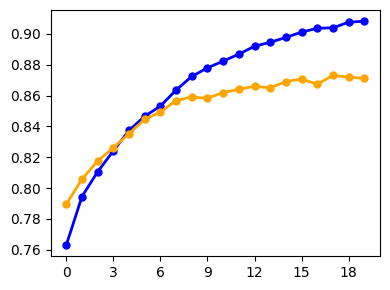

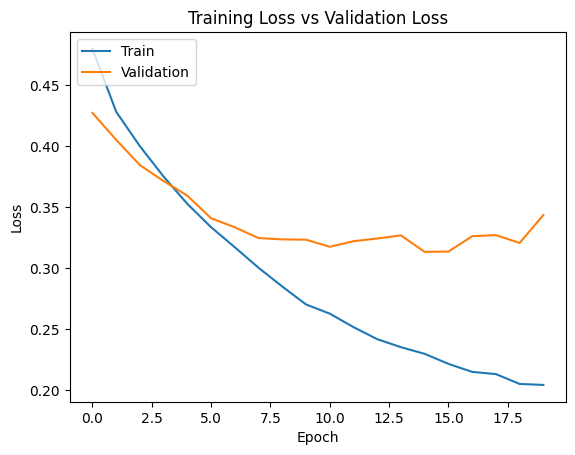

Test set evaluation
28/28 - 1s - loss: 0.8063 - acc: 0.7878 - 717ms/epoch - 26ms/step
(50000, 50, 50)
(50000, 2)
imdb set evaluation
1563/1563 - 40s - loss: 1.6132 - acc: 0.6470 - 40s/epoch - 26ms/step


INFO: loading projection weights from C:\Users\Kiann/gensim-data\glove-wiki-gigaword-300\glove-wiki-gigaword-300.gz
INFO: KeyedVectors lifecycle event {'msg': 'loaded (400000, 300) matrix of type float32 from C:\\Users\\Kiann/gensim-data\\glove-wiki-gigaword-300\\glove-wiki-gigaword-300.gz', 'binary': False, 'encoding': 'utf8', 'datetime': '2024-04-14T06:09:57.342685', 'gensim': '4.3.2', 'python': '3.9.19 (main, Mar 21 2024, 17:21:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19045-SP0', 'event': 'load_word2vec_format'}


Preprocessing text to remove stopwords
No. of 339251 unique tokens.
Failed to tokenize 14329 words
No. of 339251 unique tokens.
Failed to tokenize 340 words
No. of 208827 unique tokens.
Failed to tokenize 95367 words
Shape of data tensor: (67349, 50, 50)
Shape of label tensor: (67349, 2)
Shape of data tensor: (872, 50, 50)
Shape of label tensor: (872, 2)
Shape of data tensor: (50000, 50, 50)
Shape of label tensor: (50000, 2)
Converted 337393 words (1858 misses)
Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 50)]              0         
                                                                 
 embedding_5 (Embedding)     (None, 50, 300)           101775600 
                                                                 
 bidirectional_10 (Bidirecti  (None, 50, 200)          320800    
 onal)                                                

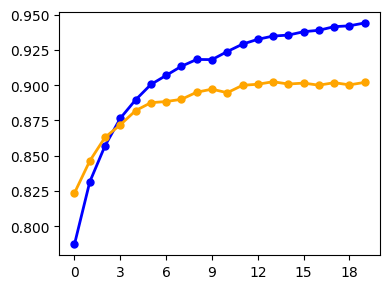

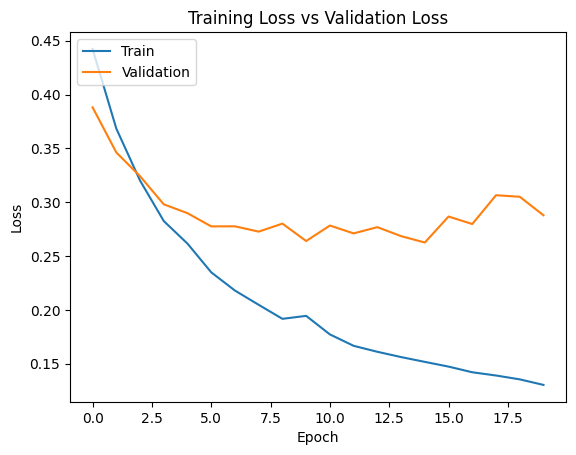

Test set evaluation
28/28 - 1s - loss: 0.7724 - acc: 0.7810 - 712ms/epoch - 25ms/step
(50000, 50, 50)
(50000, 2)
imdb set evaluation
1563/1563 - 40s - loss: 1.5439 - acc: 0.6834 - 40s/epoch - 25ms/step


INFO: loading projection weights from C:\Users\Kiann/gensim-data\glove-wiki-gigaword-100\glove-wiki-gigaword-100.gz
INFO: KeyedVectors lifecycle event {'msg': 'loaded (400000, 100) matrix of type float32 from C:\\Users\\Kiann/gensim-data\\glove-wiki-gigaword-100\\glove-wiki-gigaword-100.gz', 'binary': False, 'encoding': 'utf8', 'datetime': '2024-04-14T06:41:07.746461', 'gensim': '4.3.2', 'python': '3.9.19 (main, Mar 21 2024, 17:21:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19045-SP0', 'event': 'load_word2vec_format'}


Preprocessing text to remove stopwords
No. of 339251 unique tokens.
Failed to tokenize 14329 words
No. of 339251 unique tokens.
Failed to tokenize 340 words
No. of 208827 unique tokens.
Failed to tokenize 95367 words
Shape of data tensor: (67349, 50, 50)
Shape of label tensor: (67349, 2)
Shape of data tensor: (872, 50, 50)
Shape of label tensor: (872, 2)
Shape of data tensor: (50000, 50, 50)
Shape of label tensor: (50000, 2)
Converted 337393 words (1858 misses)
Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 50)]              0         
                                                                 
 embedding_6 (Embedding)     (None, 50, 100)           33925200  
                                                                 
 bidirectional_12 (Bidirecti  (None, 50, 200)          160800    
 onal)                                                

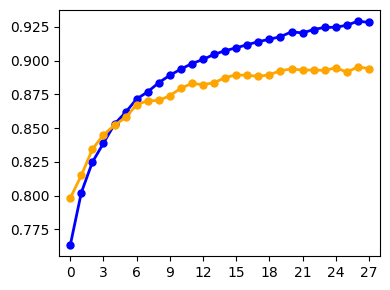

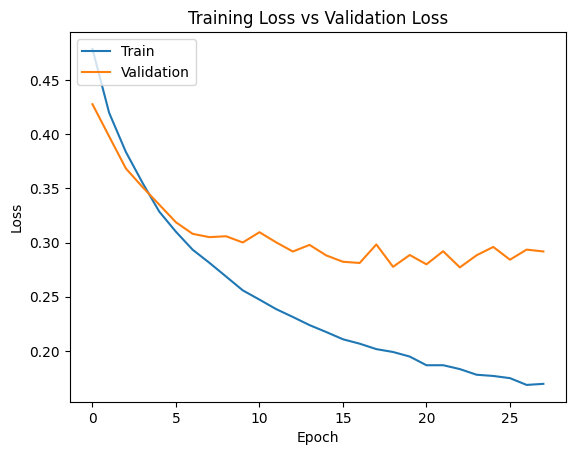

Test set evaluation
28/28 - 1s - loss: 0.7083 - acc: 0.7970 - 565ms/epoch - 20ms/step
(50000, 50, 50)
(50000, 2)
imdb set evaluation
1563/1563 - 31s - loss: 1.2304 - acc: 0.7031 - 31s/epoch - 20ms/step


INFO: loading projection weights from C:\Users\Kiann/gensim-data\glove-wiki-gigaword-200\glove-wiki-gigaword-200.gz
INFO: KeyedVectors lifecycle event {'msg': 'loaded (400000, 200) matrix of type float32 from C:\\Users\\Kiann/gensim-data\\glove-wiki-gigaword-200\\glove-wiki-gigaword-200.gz', 'binary': False, 'encoding': 'utf8', 'datetime': '2024-04-14T07:12:45.071814', 'gensim': '4.3.2', 'python': '3.9.19 (main, Mar 21 2024, 17:21:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19045-SP0', 'event': 'load_word2vec_format'}


Preprocessing text to remove stopwords
No. of 339251 unique tokens.
Failed to tokenize 14329 words
No. of 339251 unique tokens.
Failed to tokenize 340 words
No. of 208827 unique tokens.
Failed to tokenize 95367 words
Shape of data tensor: (67349, 50, 50)
Shape of label tensor: (67349, 2)
Shape of data tensor: (872, 50, 50)
Shape of label tensor: (872, 2)
Shape of data tensor: (50000, 50, 50)
Shape of label tensor: (50000, 2)
Converted 337393 words (1858 misses)
Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 50)]              0         
                                                                 
 embedding_7 (Embedding)     (None, 50, 200)           67850400  
                                                                 
 bidirectional_14 (Bidirecti  (None, 50, 200)          240800    
 onal)                                                

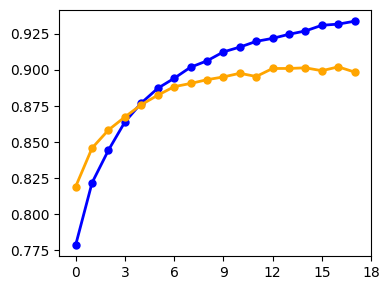

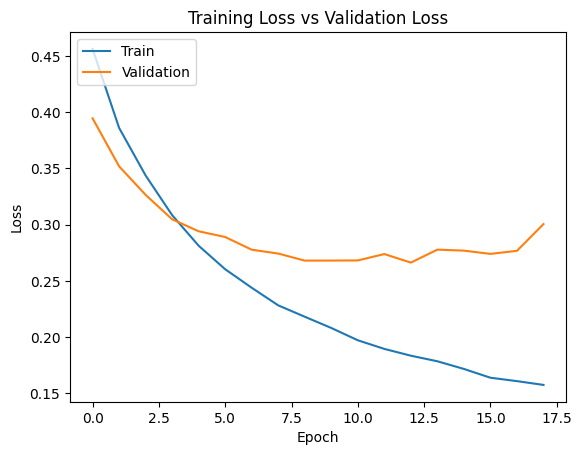

Test set evaluation
28/28 - 1s - loss: 0.8261 - acc: 0.7798 - 647ms/epoch - 23ms/step
(50000, 50, 50)
(50000, 2)
imdb set evaluation
1563/1563 - 36s - loss: 1.4029 - acc: 0.7030 - 36s/epoch - 23ms/step


In [16]:
for model_type in ['word2vec-google-news-300','glove-wiki-gigaword-300','glove-wiki-gigaword-100', 'glove-wiki-gigaword-200']:
        w2vModel = api.load(model_type)
        GLOVE_DIM = int(model_type.split('-')[-1])

        # Reset dataframes
        print('Preprocessing text to remove stopwords')
        df_train = df_train_pre.copy()
        df_test = df_test_pre.copy()
        df_imdb_ori = df_imdb_pre.copy()
        # Tokenize all data for HAN
        texts = df_train['content']
        test_text = df_test['content']
        imdb_text = df_imdb['content']


        # Get all sentences
        test_articles = test_text.map(lambda x: sent_tokenize(x))

        # Create 3D data with tokenizer word_index. Neglect words which are not in word_index
        tokenizer = Tokenizer(num_words=max_number_of_words)

        # Fit word2vec vocab list onto tokenizer
        words = list(w2vModel.index_to_key)
        tokenizer.fit_on_texts(words)


        # tokenizer.fit_on_texts(texts)
        word_index = tokenizer.word_index

        # # Tokenize train test data
        data = Tokenize(texts, max_sent_length, max_number_of_sent, max_number_of_words, tokenizer, word_index)
        test_data = Tokenize(test_text, max_sent_length, max_number_of_sent, max_number_of_words, tokenizer, word_index)

        # Just to get the unique token count, still use original tokenizer
        imdb_tokenizer = Tokenizer(num_words=max_number_of_words)
        imdb_tokenizer.fit_on_texts(imdb_text)
        imdb_word_index = imdb_tokenizer.word_index

        imdb_data = Tokenize(imdb_text, max_sent_length, max_number_of_sent, max_number_of_words, tokenizer, imdb_word_index)

        # # Split training and validation sets
        xtrain, ytrain, xval, yval = Train_Val_Split(data,df_train, 0.2)
        xtest, ytest, _, _ = Train_Val_Split(test_data,df_test, 0)
        xtrain_imdb, ytrain_imdb, _, _ = Train_Val_Split(imdb_data,df_imdb,0)
        wordLen = len(tokenizer.word_index)+1

        # Make word2vec embedding 3D weight matrix
        embedding_matrix = embed (w2vModel, tokenizer, GLOVE_DIM)
        
        # Evaluate model
        history, han_model = evaluate_model(xtrain, ytrain, xval, yval, wordLen, GLOVE_DIM, embedding_matrix)

        print(f"Evaluation of {model_type}" + " (Preprocessed no stopwords)")
        # Final Summary of run
        print_stats(history)
        # Evaluate model on sst test dataset
        print("Test set evaluation")
        result = han_model.evaluate(xtest, ytest, verbose=2)

        # Evaluate model on imdb dataset
        print(xtrain_imdb.shape)
        print(ytrain_imdb.shape)

        print("imdb set evaluation")
        result = han_model.evaluate(xtrain_imdb, ytrain_imdb, verbose=2)